In [6]:
import os
import sys

# allow importing from parent directory
current_folder = globals()['_dh'][0]
data_location = os.path.join(current_folder,'data.csv')
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(data_location), '..')))

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import display

from ultralytics import settings
settings.update({"sync": False, "runs_dir": "interim_results"})
from ultralytics import YOLOEdgeUncertainty, YOLO
import cv2
import re
import datetime

FONT_SMALL = 16
FONT_MEDIUM = 18
FONT_LARGE = 20

plt.rcParams['font.size'] = FONT_LARGE
plt.rcParams['axes.labelsize'] = FONT_MEDIUM
plt.rcParams['xtick.labelsize'] = FONT_SMALL
plt.rcParams['ytick.labelsize'] = FONT_SMALL
plt.rcParams['legend.fontsize'] = FONT_SMALL
plt.rcParams['figure.titlesize'] = FONT_MEDIUM
plt.rcParams['axes.titlesize'] = FONT_MEDIUM
plt.rcParams['figure.figsize'] = (16, 8)

In [7]:
order = ["base-pretrained", "base-confidence", "base-uncertainty", "dfl-uncertainty", "ensemble", "mc-dropout", "edl-meh"]

path_base = '../interim_results/detect'
newest_results = 'data_splits_and_models'
print(f'Results folder: {newest_results}')

datasets = {}
train_dataset_path = [f for f in os.listdir(f'{path_base}/{newest_results}') if f.startswith('train') and os.path.isdir(f'{path_base}/{newest_results}/{f}')][0]
print(f'Train dataset path: {train_dataset_path}')

for dataset_type in ['val']:
    dataset_paths = [f for f in os.listdir(f'{path_base}/{newest_results}') if f.startswith(dataset_type) and os.path.isdir(f'{path_base}/{newest_results}/{f}')]

    for dataset_path in dataset_paths:
        full_dataset_path = f'{path_base}/{newest_results}/{dataset_path}'
        df_results = pd.DataFrame()

        for model_folder in [f for f in os.listdir(full_dataset_path) if os.path.isdir(f'{full_dataset_path}/{f}')]:
            df_results_model = pd.read_csv(f'{full_dataset_path}/{model_folder}/results_extended.csv')

            if df_results.empty:
                df_results = df_results_model
            else:
                df_results = pd.concat([df_results, df_results_model])

        df_results.set_index('name', inplace=True)
        df_results = df_results.loc[order, :]

        # complement mUE metric, so higher is better now
        df_results['1 - metrics/mUE50'] = 1 - df_results['metrics/mUE50']
        df_results.drop(columns=['metrics/mUE50'], inplace=True)
        df_results['1 - metrics/mUE50-95'] = 1 - df_results['metrics/mUE50-95']
        df_results.drop(columns=['metrics/mUE50-95'], inplace=True)
        df_results['1 - metrics/mUE50_correct'] = 1 - df_results['metrics/mUE50_correct']
        df_results.drop(columns=['metrics/mUE50_correct'], inplace=True)
        df_results['1 - metrics/mUE50-95_correct'] = 1 - df_results['metrics/mUE50-95_correct']
        df_results.drop(columns=['metrics/mUE50-95_correct'], inplace=True)
        df_results['1 - metrics/mUE50_incorrect'] = 1 - df_results['metrics/mUE50_incorrect']
        df_results.drop(columns=['metrics/mUE50_incorrect'], inplace=True)
        df_results['1 - metrics/mUE50-95_incorrect'] = 1 - df_results['metrics/mUE50-95_incorrect']
        df_results.drop(columns=['metrics/mUE50-95_incorrect'], inplace=True)

        speed_cols = [col for col in df_results.columns if 'speed' in col]
        df_results['speed_total'] = df_results[speed_cols].sum(axis=1)
        datasets[dataset_path] = df_results

for key, df in datasets.items():
    print(f'Dataset: {key}')
    display(df)

Results folder: data_splits_and_models
Train dataset path: train-cityscapes-train-kitti-val-from-coco80
Dataset: val-foggy-cityscapes-from-coco80


metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
name                                                                          
base-pretrained               0.401346           0.235761          0.238946   
base-confidence               0.456488           0.276978          0.276859   
base-uncertainty              0.456488           0.276978          0.276859   
dfl-uncertainty               0.456488           0.276978          0.276859   
ensemble                      0.695390           0.143249          0.191190   
mc-dropout                    0.433935           0.265888          0.266072   
edl-meh                       0.441125           0.260921          0.268824   

                  metrics/mAP50-95(B)  metrics/mUE50_thres  \
name                                                         
base-pretrained              0.152673                 0.96   
base-confidence              0.174042                 0.91   
base-uncertainty             0.174042                 6.31   
dfl-uncertainty              0.174042                 0.81   
ensemble                     0.123794                 0.66   
mc-dropout                   0.165722                 0.31   
edl-meh                      0.170182                 0.76   

                  metrics/mUE50-95_thres   fitness  speed_preprocess  \
name                                                                   
base-pretrained                    0.860  0.510937          0.081208   
base-confidence                    0.845  0.529015          0.072304   
base-uncertainty                   6.310  0.406097          0.084808   
dfl-uncertainty                    0.775  0.471858          0.079684   
ensemble                           0.460  0.455271          0.065347   
mc-dropout                         0.185  0.509175          0.078044   
edl-meh                            0.520  0.514604          0.077410   

                  speed_inference  speed_loss  speed_postprocess  \
name                                                               
base-pretrained          0.734133    0.000365           0.647050   
base-confidence          0.672492    0.000363           0.693337   
base-uncertainty         0.727815    0.000350           0.711885   
dfl-uncertainty          0.410953    0.000367           0.864087   
ensemble                 1.210186    0.000354           0.621242   
mc-dropout               0.916132    0.000363           0.656890   
edl-meh                  2.275141    0.001685           0.767949   

                  1 - metrics/mUE50  1 - metrics/mUE50-95  \
name                                                        
base-pretrained            0.805823              0.866657   
base-confidence            0.822940              0.879346   
base-uncertainty           0.560855              0.635317   
dfl-uncertainty            0.703700              0.765580   
ensemble                   0.729321              0.785641   
mc-dropout                 0.785812              0.848903   
edl-meh                    0.806457              0.853907   

                  1 - metrics/mUE50_correct  1 - metrics/mUE50-95_correct  \
name                                                                        
base-pretrained                    0.909506                      0.918476   
base-confidence                    0.882466                      0.925275   
base-uncertainty                   0.561095                      0.635803   
dfl-uncertainty                    0.848597                      0.883012   
ensemble                           0.840155                      0.874938   
mc-dropout                         0.856598                      0.895083   
edl-meh                            0.881336                      0.915007   

                  1 - metrics/mUE50_incorrect  1 - metrics/mUE50-95_incorrect  \
name                                                                            
base-pretrained                      0.896316                        0.948181  

Dataset: val-kitti-from-coco80


,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),metrics/mUE50_thres,metrics/mUE50-95_thres,fitness,speed_preprocess,speed_inference,speed_loss,speed_postprocess,1 - metrics/mUE50,1 - metrics/mUE50-95,1 - metrics/mUE50_correct,1 - metrics/mUE50-95_correct,1 - metrics/mUE50_incorrect,1 - metrics/mUE50-95_incorrect,speed_total
name,,,,,,,,,,,,,,,,,,
base-pretrained,0.471603,0.383547,0.363639,0.178976,0.86,0.805,0.546126,0.033860,0.370379,0.000335,0.589591,0.871611,0.897388,0.920671,0.938907,0.950940,0.958481,0.994165
base-confidence,0.548084,0.369107,0.398554,0.199851,0.81,0.740,0.560546,0.039081,0.353550,0.000480,0.609709,0.881367,0.903593,0.921913,0.936208,0.959454,0.967385,1.002820
base-uncertainty,0.548084,0.369107,0.398554,0.199851,6.31,6.310,0.441368,0.039114,0.483872,0.000400,0.571963,0.602676,0.669719,0.602894,0.670531,0.999782,0.999188,1.095348
dfl-uncertainty,0.548084,0.369107,0.398554,0.199851,0.71,0.705,0.485244,0.039361,0.359524,0.000410,0.594345,0.699243,0.756492,0.835557,0.888607,0.863686,0.867885,0.993641
ensemble,0.829242,0.255507,0.334501,0.165333,0.31,0.195,0.498921,0.032544,0.714859,0.000320,0.479686,0.792229,0.818187,0.887413,0.892282,0.904816,0.925905,1.227408
mc-dropout,0.538200,0.364283,0.392402,0.196251,0.26,0.195,0.539929,0.037450,0.446545,0.000331,0.564286,0.842044,0.866429,0.897519,0.910517,0.944525,0.955912,1.048613
edl-meh,0.486449,0.363381,0.382449,0.191141,0.46,0.395,0.530736,0.036480,1.411787,0.000331,0.539183,0.836049,0.852884,0.906378,0.918928,0.929672,0.933956,1.987781


Dataset: val-rainy-cityscapes-from-coco80


,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),metrics/mUE50_thres,metrics/mUE50-95_thres,fitness,speed_preprocess,speed_inference,speed_loss,speed_postprocess,1 - metrics/mUE50,1 - metrics/mUE50-95,1 - metrics/mUE50_correct,1 - metrics/mUE50-95_correct,1 - metrics/mUE50_incorrect,1 - metrics/mUE50-95_incorrect,speed_total
name,,,,,,,,,,,,,,,,,,
base-pretrained,0.367428,0.241466,0.259274,0.165380,0.96,0.870,0.514172,0.092816,0.572839,0.000407,0.752425,0.797515,0.859803,0.905136,0.920258,0.892379,0.939544,1.418488
base-confidence,0.407280,0.245712,0.285786,0.178460,0.91,0.830,0.529149,0.092665,0.626144,0.000336,0.759503,0.816025,0.875003,0.875907,0.921318,0.940118,0.953685,1.478648
base-uncertainty,0.407280,0.245712,0.285786,0.178460,6.31,6.310,0.402315,0.090846,0.631865,0.000364,0.774799,0.550124,0.622694,0.550334,0.623109,0.999790,0.999585,1.497874
dfl-uncertainty,0.407280,0.245712,0.285786,0.178460,0.86,0.805,0.477971,0.091456,0.651597,0.000880,0.767722,0.707620,0.773320,0.861321,0.884463,0.846299,0.888857,1.511655
ensemble,0.699654,0.141712,0.215725,0.138193,0.91,0.540,0.462294,0.110639,1.206995,0.000358,0.533680,0.726588,0.784426,0.854053,0.873084,0.872535,0.911341,1.851672
mc-dropout,0.417307,0.237613,0.282330,0.176057,0.36,0.225,0.511611,0.085753,0.808547,0.000383,0.704605,0.768783,0.844067,0.844280,0.893742,0.924503,0.950325,1.599288
edl-meh,0.440947,0.231814,0.279431,0.175567,1.31,0.695,0.514487,0.090054,2.274466,0.000415,0.760018,0.794153,0.848451,0.911096,0.922793,0.883057,0.925657,3.124954


Dataset: val-cityscapes-from-coco80


,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),metrics/mUE50_thres,metrics/mUE50-95_thres,fitness,speed_preprocess,speed_inference,speed_loss,speed_postprocess,1 - metrics/mUE50,1 - metrics/mUE50-95,1 - metrics/mUE50_correct,1 - metrics/mUE50-95_correct,1 - metrics/mUE50_incorrect,1 - metrics/mUE50-95_incorrect,speed_total
name,,,,,,,,,,,,,,,,,,
base-pretrained,0.528370,0.276371,0.292189,0.176769,0.91,0.830,0.524528,0.162869,0.839435,0.000361,1.485274,0.811270,0.866243,0.883036,0.918340,0.928234,0.947903,2.487939
base-confidence,0.516175,0.328523,0.342015,0.204287,0.91,0.795,0.544957,0.160336,1.809115,0.000387,1.091634,0.823046,0.877278,0.909541,0.923538,0.913505,0.953740,3.061472
base-uncertainty,0.516175,0.328523,0.342015,0.204287,6.31,6.310,0.424655,0.154285,1.790789,0.004330,1.192094,0.561334,0.639018,0.561577,0.639523,0.999757,0.999495,3.141498
dfl-uncertainty,0.516175,0.328523,0.342015,0.204287,0.76,0.740,0.475801,0.158933,1.221266,0.000399,1.836305,0.681246,0.739353,0.828087,0.868068,0.853159,0.871284,3.216903
ensemble,0.488926,0.176289,0.224598,0.138602,0.61,0.375,0.464579,0.151597,2.804448,0.000391,0.699186,0.728613,0.787883,0.845636,0.874782,0.882977,0.913102,3.655622
mc-dropout,0.491708,0.316284,0.324617,0.193804,0.31,0.195,0.524768,0.157189,1.555873,0.000401,1.608725,0.788818,0.848632,0.860288,0.898357,0.928529,0.950274,3.322188
edl-meh,0.438810,0.320704,0.330339,0.198020,0.76,0.470,0.526419,0.120149,3.333754,0.000441,1.661240,0.798761,0.846344,0.891784,0.915133,0.906977,0.931210,5.115582


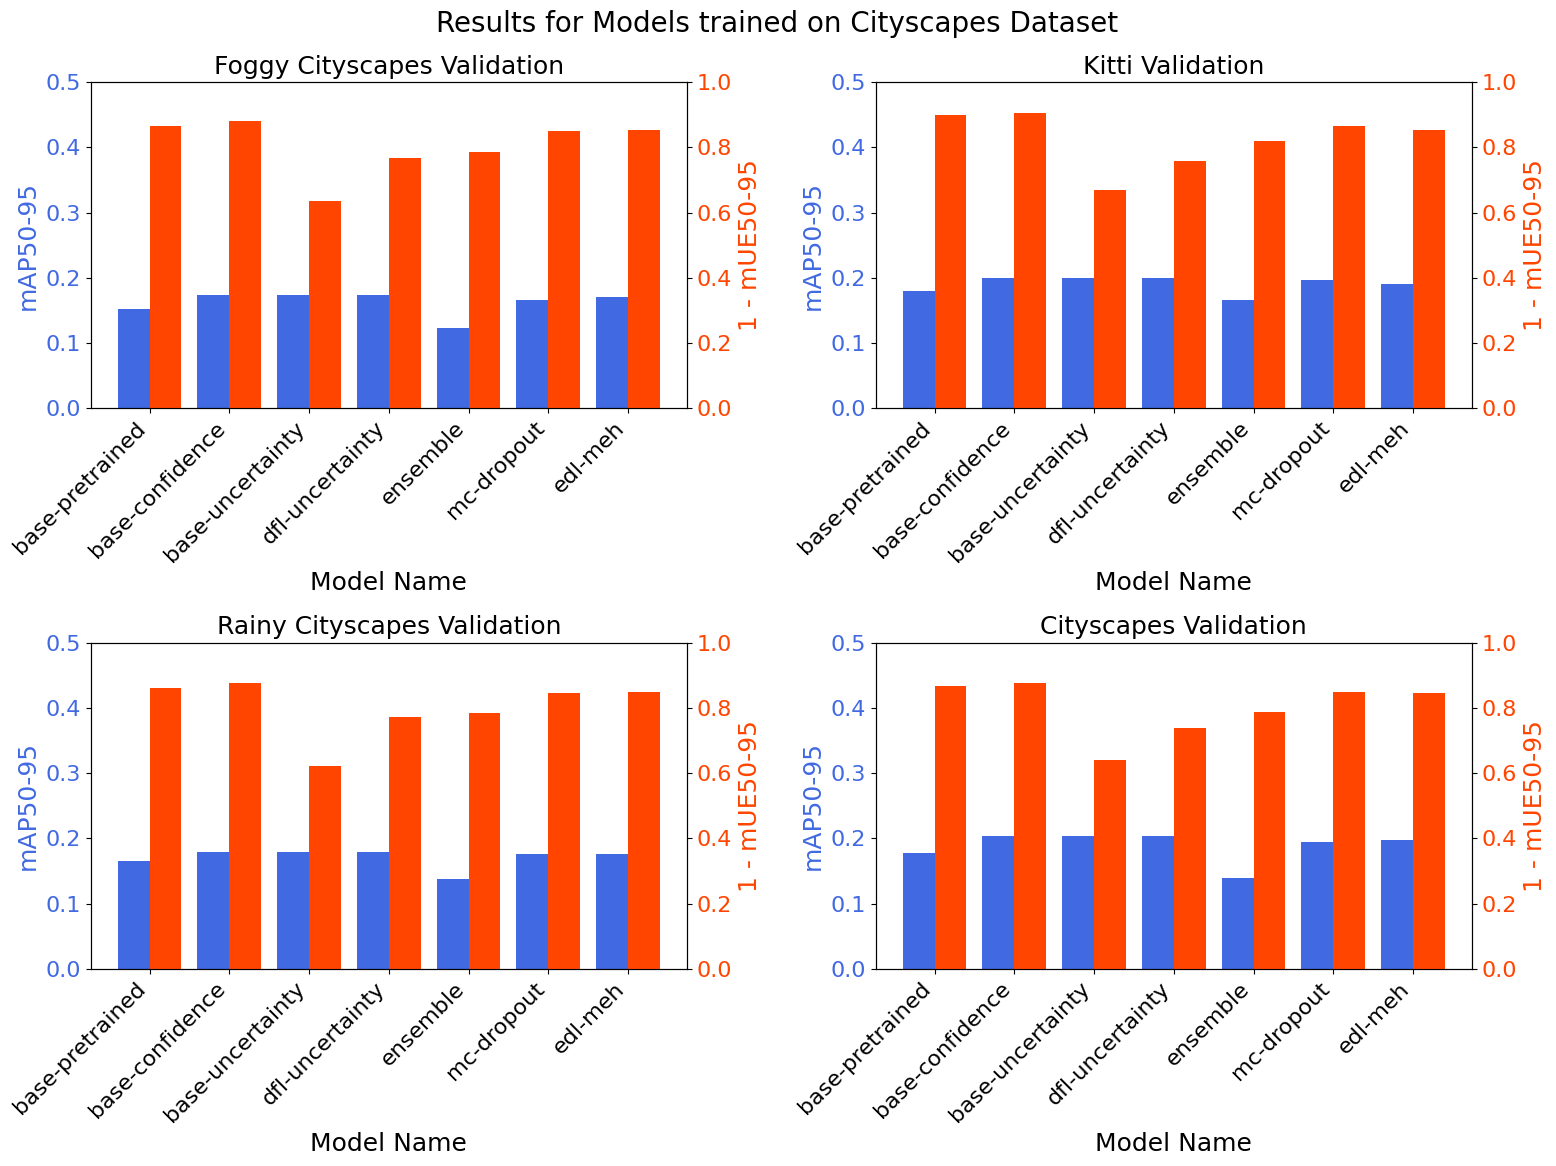

In [8]:
metric1 = 'metrics/mAP50-95(B)'
metric2 = '1 - metrics/mUE50-95'

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.flatten()

for idx, (key, df) in enumerate(datasets.items()):
    if idx >= 4:
        break
    ax1 = axs[idx]

    color_1 = 'royalblue'
    ax1.set_xlabel('Model Name')
    ax1.set_ylabel(metric1.replace('metrics/', '').replace('(B)', ''), color=color_1)
    ax1.bar(df.index, df[metric1], color=color_1, width=0.4, label=metric1)
    ax1.tick_params(axis='y', labelcolor=color_1)

    ax2 = ax1.twinx()
    color_2 = 'orangered'
    ax2.set_ylabel(metric2.replace('metrics/', ''), color=color_2)
    ax2.bar([i + 0.4 for i in range(len(df.index))], df[metric2], color=color_2, width=0.4, label=metric2)
    ax2.tick_params(axis='y', labelcolor=color_2)

    ax1.set_xticks([i + 0.2 for i in range(len(df.index))])
    ax1.set_xticklabels(df.index, rotation=45, ha='right')
    ax1.set_title(f"{key.replace('val-', '').replace('-from-coco80', '').replace('-', ' ').title()} Validation")

    ax1.set_ylim(0, 0.5)
    ax2.set_ylim(0, 1.0)
fig.tight_layout()

fig.suptitle(f"Results for Models trained on {train_dataset_path.split('train')[1].replace('-', '').title()} Dataset", fontsize=FONT_LARGE)
plt.subplots_adjust(top=0.92)

plt.show()

In [9]:
chosen_val_dataset = 'val-kitti-from-coco80'
path = f'{path_base}/{newest_results}/{chosen_val_dataset}'
df_selected = datasets[chosen_val_dataset]

names_title_case = df_selected.index.str.replace('-', ' ').str.title().str.replace('Edl', 'EDL').str.replace('Meh', 'MEH').str.replace('Dfl', 'DFL').str.replace('Mc', 'MC').values
print(names_title_case)

['Base Pretrained' 'Base Confidence' 'Base Uncertainty' 'DFL Uncertainty' 'Ensemble' 'MC Dropout' 'EDL MEH']


,Precision,Recall,mAP50-95,FPS,1 - mUE50-95
name,,,,,
Base Pretrained,1.000000,1.000000,1.000000,1.000000,1.000000
Base Confidence,1.162172,0.962352,1.116639,0.991370,1.006915
Base Uncertainty,1.162172,0.962352,1.116639,0.907625,0.746298
DFL Uncertainty,1.162172,0.962352,1.116639,1.000528,0.842993
Ensemble,1.758349,0.666169,0.923774,0.809971,0.911743
MC Dropout,1.141214,0.949774,1.096524,0.948076,0.965501
EDL MEH,1.031480,0.947423,1.067971,0.500138,0.950407


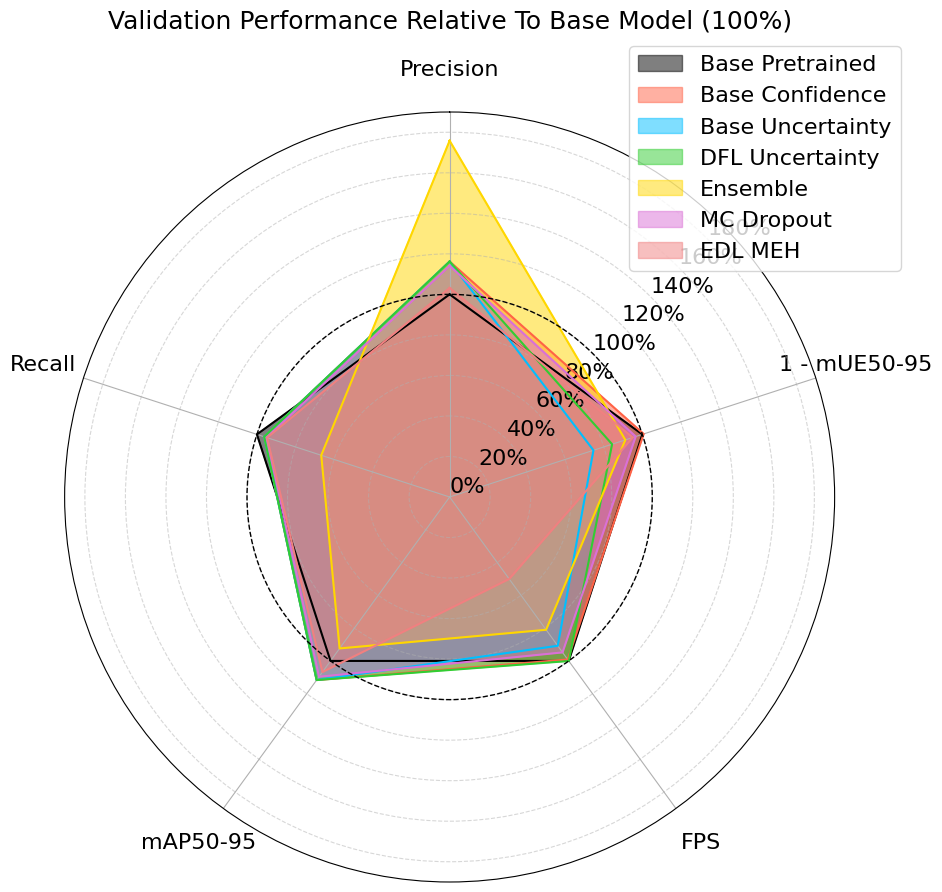

In [14]:
rename_dict_index = {k: v for k, v in zip(df_selected.index.values, names_title_case)}

rename_dict_cols = {
    'metrics/precision(B)' : 'Precision',
    'metrics/recall(B)' : 'Recall',
    'metrics/mAP50-95(B)' : 'mAP50-95',
    'speed_total' : 'FPS',
    '1 - metrics/mUE50-95' : '1 - mUE50-95',
}

color_list = ['k', 'tomato', 'deepskyblue', 'limegreen', 'gold', 'orchid', 'lightcoral', 'lightseagreen']
colors = {idx: color for idx, color in zip(names_title_case, color_list[:len(names_title_case)])}

df = df_selected[rename_dict_cols.keys()]
# take inverse of inference time as fps
df.loc[:, 'speed_total'] = 1 / df['speed_total']
# take base index, and normalize all values to it
df = df / df.iloc[0]

df.rename(index=rename_dict_index, inplace=True)
df.rename(columns=rename_dict_cols, inplace=True)


display(df)

categories = list(df.columns)
num_vars = len(categories)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Repeat the first angle to close the plot

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

for idx in df.index:
    values = df.loc[idx].tolist()
    values += values[:1]  # Repeat the first value to close the plot
    ax.fill(angles, values, alpha=0.50, color=colors[idx], label=idx)
    ax.plot(angles, values, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

ylim = round(max(df.max()), 1) + 0.1
ax.set_ylim(0, ylim)

plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

ax.tick_params(axis='x', pad=20)
ax.set_yticks(np.arange(0, ylim, 0.2))
ax.set_yticklabels(ax.get_yticks(), rotation=45)

ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
ax.set_theta_offset(np.pi / 2)

ax.yaxis.grid(True, linestyle='--', alpha=0.5)
ax.axhline(1, color='black', linewidth=1, linestyle='--')
ax.set_rlabel_position(-45)
ax.set_title(f"{'Training' if 'train' in path else 'Validation'} Performance relative to base model (100%)".title(), pad=60)
ax.title.set_position([.5, 1.4])

plt.savefig(f'{path}/radar_chart.png', bbox_inches='tight', dpi=600)
plt.savefig(f'{path}/radar_chart.pdf', bbox_inches='tight')
plt.show()